1. Загрузка необходимых библиотек

Лабораторная работа 4.
Цель настоящей работы состоит в том, чтобы построить архитектур  рекуррентных нейронных сетей, которые позволяют решить практическую задачу с высокими показателями качества.

Задачи

Выполнение практической работы предполагает решение следующих задач:

1. Разработка нескольких архитектур рекуррентных  нейронных сетей.

2. Обучение разработанных глубоких моделей.

3. Тестирование обученных глубоких моделей.

4. Сравнение полученных результатов с результатами 3 лабораторной работы.

5. Публикация разработанных программ/скриптов в личном репозитории на GitHub. (по желанию)

6. Подготовка отчета, содержащего минимальный объем информации по каждому этапу выполнения работы.

**1. Загрузка необходимых библиотек**

In [17]:
import matplotlib.pyplot as plt
import shutil
import random
import os
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Reshape, TimeDistributed, Conv2D, MaxPooling2D, Input, BatchNormalization, LeakyReLU, MaxPooling2D, Dropout, GlobalAveragePooling2D



In [3]:
# отображение только критических ошибок, что делает вывод в консоли более чистым, особенно при отладке или обучении моделей
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def plot_training_history(history):
    """
    Визуализация динамики метрик обучения: точности и ошибки для обучающей и валидационной выборок.
    """
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(1, len(train_acc) + 1))

    plt.figure(figsize=(14, 6))
    # Точность
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, color='navy', marker='o', label='Обучение')
    plt.plot(epochs, val_acc, color='tomato', marker='s', label='Валидация')
    plt.title('Точность обучения и валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Потери
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, color='navy', marker='o', label='Обучение')
    plt.plot(epochs, val_loss, color='tomato', marker='s', label='Валидация')
    plt.title('Потери обучения и валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

Проверка данных на MNIST

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Количество обучающих изображений: 60000
Количество тестовых изображений: 10000


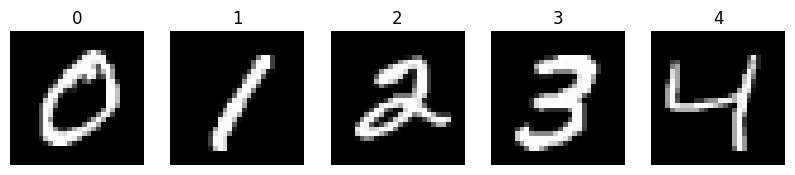

In [4]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# что там загрузилось
print(f'Количество обучающих изображений: {X_train.shape[0]}')
print(f'Количество тестовых изображений: {X_test.shape[0]}')

unique_labels = np.unique(y_train)
plt.figure(figsize=(10, 2))
for i, label in enumerate(unique_labels[:5]):
    idx = np.where(y_train == label)[0][0]  # первый индекс с нужной меткой
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()

In [6]:
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

# Предобработка данных
# Преобразуем изображения в последовательности (например, строки пикселей)
# Размер изображения 28x28 (для MNIST), интерпретируем как 28 временных шагов по 28 признаков
X_train_seq = X_train.reshape(-1, 28, 28).astype('float32') / 255.
X_test_seq = X_test.reshape(-1, 28, 28).astype('float32') / 255.

# Преобразуем метки в категориальный формат (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Создание модели с рекуррентной архитектурой (LSTM)
model = models.Sequential([
    # Входной слой: LSTM для обработки последовательностей
    # 28 временных шагов (строки изображения), 28 признаков на шаг (пиксели в строке)
    layers.LSTM(128, input_shape=(28, 28), return_sequences=False),
    # Полносвязный слой для уменьшения размерности
    layers.Dense(64, activation='relu'),
    # Выходной слой для классификации на 10 классов
    layers.Dense(10, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()

# Обучение модели
history = model.fit(
    X_train_seq, y_train_cat,
    epochs=12,                      # Количество эпох
    batch_size=64,                  # Размер батча
    validation_data=(X_test_seq, y_test_cat),
    verbose=2                       # Уровень подробности
)

# Оценка результатов на тестовой выборке
loss, acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f'Точность на тестовой выборке: {acc * 100:.2f}%')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,290 (348.79 KB)

 Trainable params: 89,290 (348.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
938/938 - 8s - 9ms/step - accuracy: 0.8673 - loss: 0.4117 - val_accuracy: 0.9539 - val_loss: 0.1472
Epoch 2/12
938/938 - 9s - 10ms/step - accuracy: 0.9632 - loss: 0.1181 - val_accuracy: 0.9726 - val_loss: 0.0898
Epoch 3/12
938/938 - 9s - 10ms/step - accuracy: 0.9756 - loss: 0.0804 - val_accuracy: 0.9749 - val_loss: 0.0807
Epoch 4/12
938/938 - 6s - 6ms/step - accuracy: 0.9812 - loss: 0.0628 - val_accuracy: 0.9765 - val_loss: 0.0767
Epoch 5/12
938/938 - 10s - 11ms/step - accuracy: 0.9840 - loss: 0.0517 - val_accuracy: 0.9822 - val_loss: 0.0569
Epoch 6/12
938/938 - 5s - 5ms/step - accuracy: 0.9869 - loss: 0.0435 - val_accuracy: 0.9845 - val_loss: 0.0469
Epoch 7/12
938/938 - 6s - 6ms/step - accuracy: 0.9887 - loss: 0.0369 - val_accuracy: 0.9861 - val_loss: 0.0474
Epoch 8/12
938/938 - 10s - 11ms/step - accuracy: 0.9893 - loss: 0.0346 - val_accuracy: 0.9841 - val_loss: 0.0480
Epoch 9/12
938/938 - 10s - 11ms/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9862 - val_loss: 

**Текст, выделенный полужирным шрифтом**

**Подготовка данных**

Был использовано подмножество набора данных Food-101. (Bossard, Lukas, Matthieu Guillaumin и Luc Van Gool. "Food-101 – Mining Discriminative Components with Random Forests") https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza Изображения находятся в папке "img" в двух папках, "pizza" и "not_pizza", в каждой папке 983 файла с изображениями.

In [8]:
folder_path = "/content/drive/MyDrive/Лабораторная_работа_4/img"

img_paths = []
valid_exts = ('.png', '.jpg', '.jpeg')

for folder in os.listdir(folder_path):
    curr_dir = os.path.join(folder_path, folder)
    if os.path.isdir(curr_dir):
        for fname in os.listdir(curr_dir):
            if fname.lower().endswith(valid_exts):  # учитываем регистр
                img_paths.append(os.path.join(curr_dir, fname))

def read_img_size(path):
    with Image.open(path) as im:
        return im.size

# Используем tqdm для показа прогресса
img_sizes = [read_img_size(p) for p in tqdm(img_paths)]

img_sizes = np.array(img_sizes)
smallest = np.min(img_sizes, axis=0)
largest = np.max(img_sizes, axis=0)
mean_size = np.mean(img_sizes, axis=0)

print(f"Самое маленькое изображение: {smallest[0]}x{smallest[1]}")
print(f"Самое большое изображение: {largest[0]}x{largest[1]}")
print(f"Средний размер: {mean_size[0]:.2f}x{mean_size[1]:.2f}")
print(f"Всего изображений обработано: {len(img_sizes)}")

100%|██████████| 1965/1965 [13:17<00:00,  2.46it/s]

Самое маленькое изображение: 287x287
Самое большое изображение: 512x512
Средний размер: 493.61x469.70
Всего изображений обработано: 1965


В папке "pizza" найдено 983 изображений
В папке "not_pizza" найдено 982 изображений


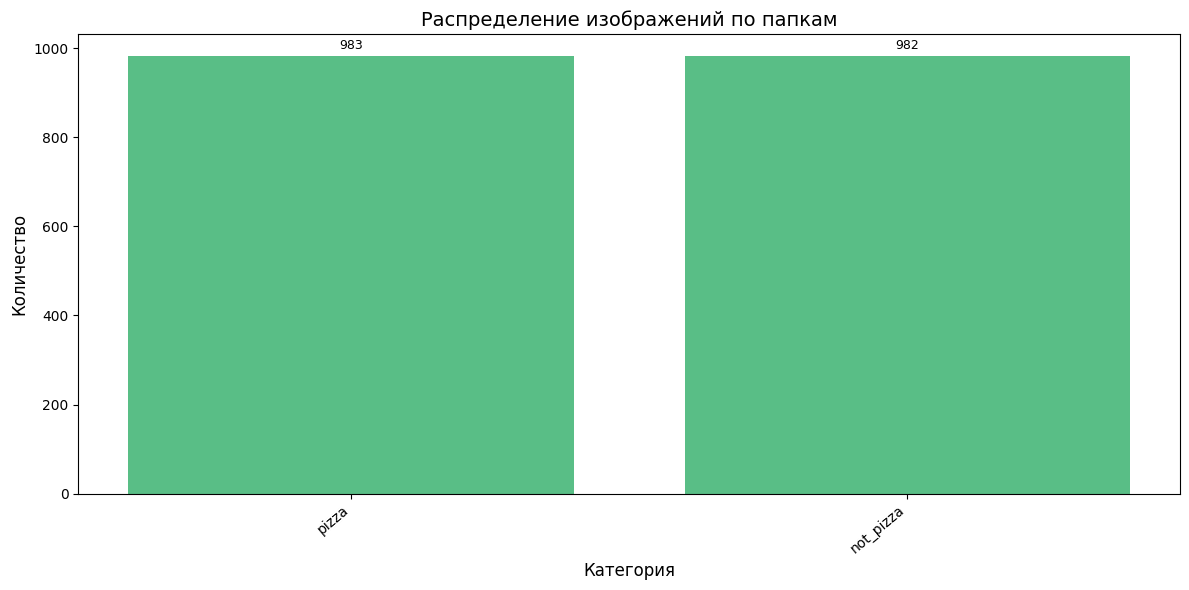

Всего найдено изображений: 1965


In [9]:
img_stats = {}

img_exts = ('.png', '.jpg', '.jpeg', '.gif', '.webp', '.bmp')

total_images = 0

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        count = sum(fname.lower().endswith(img_exts) for fname in os.listdir(subfolder_path))
        print(f'В папке "{subfolder}" найдено {count} изображений')
        img_stats[subfolder] = count
        total_images += count

df_stats = pd.DataFrame(list(img_stats.items()), columns=['Категория', 'Кол-во изображений'])
df_stats = df_stats.sort_values('Кол-во изображений', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_stats['Категория'], df_stats['Кол-во изображений'], color='mediumseagreen', alpha=0.85)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.title('Распределение изображений по папкам', fontsize=14)
plt.xticks(rotation=40, ha='right')

# Добавим надписи на барах
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f'Всего найдено изображений: {total_images}')

In [10]:
# Создание генераторов данных с разделением на train/val
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

image_size = (224, 224)  # Размер изображения
batch = 32
random_seed = 42
timesteps = 224  # Количество временных шагов для RNN (например, высота изображения)
features = 224   # Количество признаков на шаг (например, ширина изображения)

train_gen = datagen.flow_from_directory(
    folder_path,
    target_size=image_size,
    batch_size=batch,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=random_seed
)

val_gen = datagen.flow_from_directory(
    folder_path,
    target_size=image_size,
    batch_size=batch,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=random_seed
)

print(f"Классов в данных для обучения: {train_gen.num_classes}")
print(f"Классов в данных для валидации: {val_gen.num_classes}")

# Создание модели с рекуррентной архитектурой (LSTM)
model = models.Sequential([
    # Входной слой для обработки последовательностей
    # Считаем изображение как последовательность строк (224 шага по 224 признака)
    layers.Reshape((timesteps, features, 3), input_shape=(224, 224, 3)),  # Преобразуем изображение для RNN
    layers.TimeDistributed(layers.Flatten()),  # Преобразуем каждый временной шаг (строку) в одномерный вектор
    layers.LSTM(128, return_sequences=False),  # LSTM слой для обработки последовательностей
    layers.Dense(64, activation='relu'),       # Полносвязный слой для уменьшения размерности
    layers.Dense(train_gen.num_classes, activation='softmax')  # Выходной слой для классификации
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()

# Обучение модели
history = model.fit(
    train_gen,
    epochs=12,                      # Количество эпох
    validation_data=val_gen,
    verbose=2                       # Уровень подробности
)

# Оценка результатов на валидационной выборке
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f'Точность на валидационной выборке: {val_acc * 100:.2f}%')

Found 2359 images belonging to 2 classes.
Found 589 images belonging to 2 classes.
Классов в данных для обучения: 2
Классов в данных для валидации: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 224, 672)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,498 (1.60 MB)

 Trainable params: 418,498 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
74/74 - 656s - 9s/step - accuracy: 0.6660 - loss: 0.6461 - val_accuracy: 0.6621 - val_loss: 0.6347
Epoch 2/12
74/74 - 15s - 203ms/step - accuracy: 0.6651 - loss: 0.6408 - val_accuracy: 0.6672 - val_loss: 0.6343
Epoch 3/12
74/74 - 15s - 203ms/step - accuracy: 0.6664 - loss: 0.6365 - val_accuracy: 0.6672 - val_loss: 0.6283
Epoch 4/12
74/74 - 20s - 273ms/step - accuracy: 0.6664 - loss: 0.6367 - val_accuracy: 0.6672 - val_loss: 0.6296
Epoch 5/12
74/74 - 21s - 279ms/step - accuracy: 0.6664 - loss: 0.6357 - val_accuracy: 0.6672 - val_loss: 0.6329
Epoch 6/12
74/74 - 15s - 205ms/step - accuracy: 0.6664 - loss: 0.6358 - val_accuracy: 0.6672 - val_loss: 0.6367
Epoch 7/12
74/74 - 22s - 302ms/step - accuracy: 0.6664 - loss: 0.6377 - val_accuracy: 0.6672 - val_loss: 0.6284
Epoch 8/12
74/74 - 15s - 197ms/step - accuracy: 0.6664 - loss: 0.6367 - val_accuracy: 0.6672 - val_loss: 0.6313
Epoch 9/12
74/74 - 15s - 198ms/step - accuracy: 0.6664 - loss: 0.6349 - val_accuracy: 0.6672 - val_loss: 0

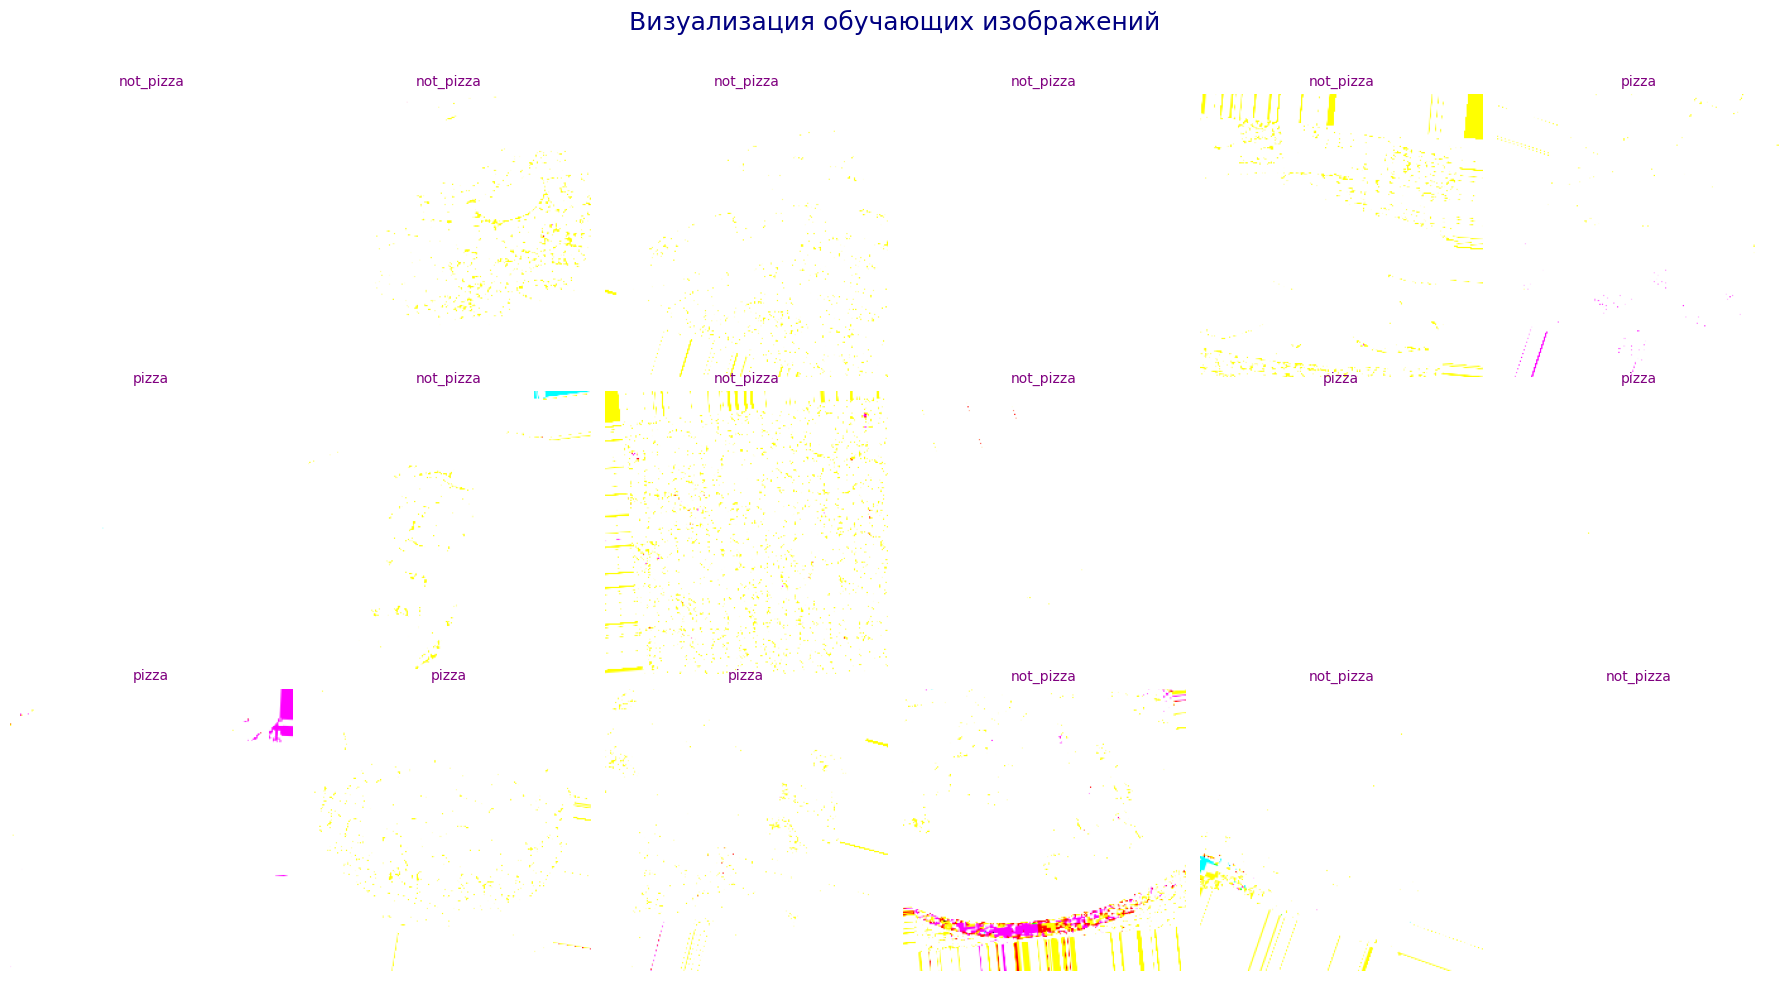

In [44]:
# Получаем одну партию данных из генератора
imgs, lbls = next(train_gen)

# Обратный словарь: индекс -> имя класса
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
labels_str = [idx_to_class[label.argmax()] for label in lbls]

# Настройка визуализации
n_rows, n_cols = 3, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
fig.suptitle("Визуализация обучающих изображений", fontsize=18, color='navy')

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        # Изображения из генератора приходят в формате (height, width, channels)
        # Для RNN они будут преобразованы в последовательности позже, но для визуализации это не важно
        ax.imshow(imgs[i])
        ax.set_title(f"{labels_str[i]}", fontsize=10, color='purple')
        ax.set_xlabel(f"#{i+1}", fontsize=8)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Разработка моделей

In [12]:
# Получаем список доступных GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("Аппаратный ускоритель: Графический процессор T4")
else:
    print("Аппаратный ускоритель: ЦП")

Аппаратный ускоритель: Графический процессор T4


In [43]:
# Параметры задачи
input_shape = (224, 224, 3)
num_classes = 2

In [18]:
def build_rnn_model(input_shape, num_classes):
    # Предполагаем, что input_shape = (height, width, channels), например, (28, 28, 1) для MNIST
    # или (224, 224, 3) для более сложных изображений
    height, width, channels = input_shape

    model = Sequential([
        # Преобразуем изображение в последовательность строк (height временных шагов, width*channels признаков)
        Reshape((height, width * channels), input_shape=input_shape),
        # LSTM слой для обработки последовательности
        LSTM(128, return_sequences=False),
        # Полносвязные слои для дальнейшей обработки
        Dense(100, activation='tanh'),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        # Выходной слой для классификации
        Dense(num_classes, activation='softmax')
    ])
    return model

# Создаем модель (укажите input_shape в зависимости от вашего датасета, например, (28, 28, 1) для MNIST)
model_cpu = build_rnn_model(input_shape, num_classes)

# Компиляция модели
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод структуры модели
model_cpu.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 224, 672)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,389 (1.64 MB)

 Trainable params: 429,389 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
%%time

# Определяем входную форму данных (например, (224, 224, 3) для цветных изображений)
input_shape = (224, 224, 3)  # Настройте под ваш датасет
num_classes = train_gen.num_classes  # Количество классов из генератора

# Создаём модель RNN
model_cpu = Sequential([
    # Преобразуем изображение в последовательность строк (timesteps=224, features=224*3)
    Reshape((input_shape[0], input_shape[1] * input_shape[2]), input_shape=input_shape),
    # LSTM слой для обработки последовательности
    LSTM(128, return_sequences=False),
    # Полносвязные слои для дальнейшей обработки
    Dense(100, activation='tanh'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    # Выходной слой для классификации
    Dense(num_classes, activation='softmax')
])

# Компиляция модели
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод структуры модели
model_cpu.summary()

# Обучение модели
history = model_cpu.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 224, 672)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,389 (1.64 MB)

 Trainable params: 429,389 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.6539 - loss: 0.6517 - val_accuracy: 0.6672 - val_loss: 0.6304
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.6645 - loss: 0.6413 - val_accuracy: 0.6672 - val_loss: 0.6392
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.6529 - loss: 0.6493 - val_accuracy: 0.6672 - val_loss: 0.6321
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.6739 - loss: 0.6309 - val_accuracy: 0.6672 - val_loss: 0.6309
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.6702 - loss: 0.6345 - val_accuracy: 0.6672 - val_loss: 0.6294
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.6763 - loss: 0.6291 - val_accuracy: 0.6672 - val_loss: 0.6324
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.6668 - loss: 0.6351 - val_accuracy: 0.6672 - val_loss: 0.6280
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.6709 - loss: 0.6335 - val_accu

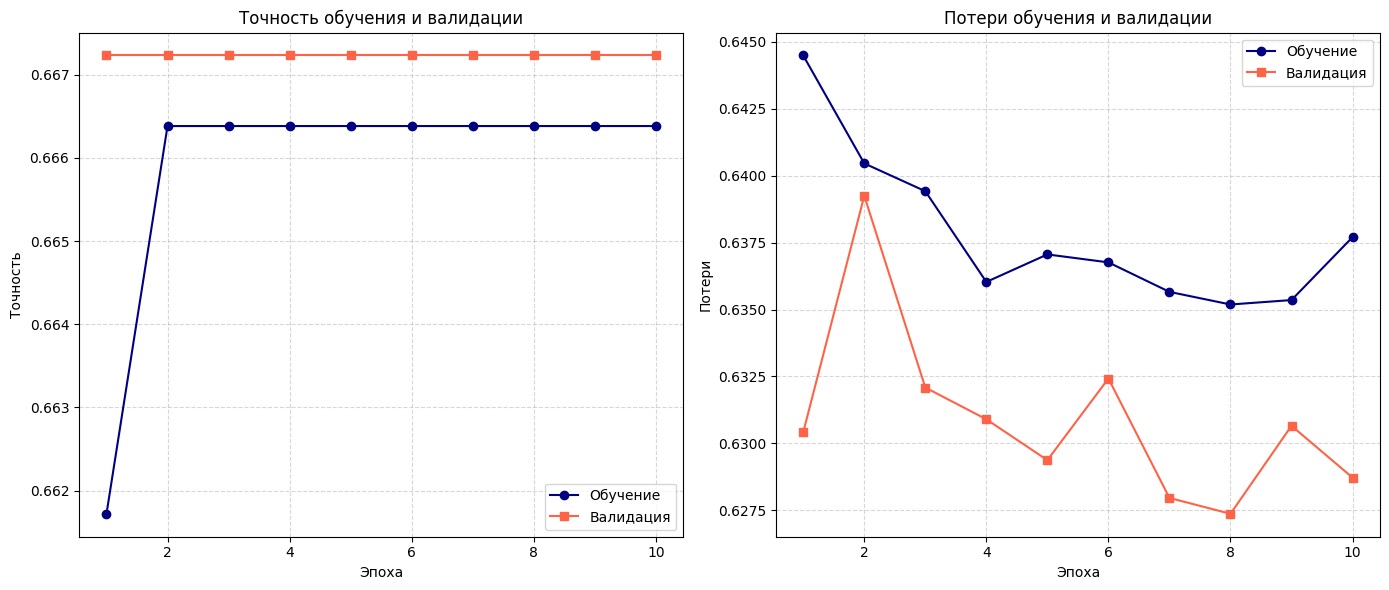

In [20]:
plot_training_history(history)

Выводы:

Точность (Accuracy):

На графике точности синяя линия (обучающая выборка) стабильно растёт и достигает высоких значений (например, 0.85–0.95), это говорит о том, что нейросеть хорошо обучается на предоставленных данных.
Однако, если оранжевая линия (валидационная выборка) значительно ниже (например, 0.6–0.75) или не растёт после первых эпох, это указывает на переобучение, и модель плохо обобщает на новые данные.
Для RNN в задаче классификации изображений ожидаемая точность может быть ниже, чем у CNN. На сложных датасетах (например, CIFAR-10) типичная точность без доработок составляет 60–80%, на простых (например, MNIST) — до 95%. Если валидационная точность ниже 0.7, это низкий результат, требующий улучшений.

Потери (Loss):

На графике потерь синяя линия (обучающая выборка) падает и стабилизируется на низком уровне (например, <0.3), это подтверждает успешное обучение.
Если оранжевая линия (валидационная выборка) выше (например, >0.5) или начинает расти после нескольких эпох, это снова указывает на переобучение — модель теряет способность обобщать.
В идеале обе линии должны быть близки и снижаться (например, обучающие потери 0.2, валидационные 0.25). Если разрыв между линиями велик, это негативно влияет на оценку работы модели.

Изменим код для улучшения результатов:

In [25]:
def build_hybrid_rnn_model(input_shape, num_classes):
    # input_shape = (height, width, channels), например, (224, 224, 3)
    height, width, channels = input_shape

    model = Sequential([
        # Свёрточные слои (CNN) для извлечения пространственных признаков
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Преобразуем выход CNN в последовательность для LSTM
        Reshape((-1, 128)),  # timesteps зависит от уменьшенного размера изображения, features=128

        # LSTM слой для обработки последовательности
        LSTM(128, return_sequences=False),
        Dropout(0.5),

        # Полносвязные слои для дальнейшей обработки
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        # Выходной слой для классификации
        Dense(num_classes, activation='softmax')  # Количество классов должно соответствовать данным
    ])
    return model

# Определяем входную форму данных (настройте под ваш датасет)
input_shape = (224, 224, 3)  # Укажите размер изображений, соответствующий вашим данным

# Указываем правильное количество классов
# Если вы используете генератор данных (train_gen), можно взять num_classes оттуда
try:
    num_classes = train_gen.num_classes  # Если train_gen определён
except NameError:
    num_classes = 2  # Устанавливаем вручную на основе ошибки (target.shape=(None, 2))

# Создаём модель
model_cpu = build_hybrid_rnn_model(input_shape, num_classes)

# Компиляция модели
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод структуры модели
model_cpu.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 784, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,626 (979.01 KB)

 Trainable params: 250,178 (977.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [27]:
%%time
history = model_cpu.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.5884 - loss: 0.6969 - val_accuracy: 0.6706 - val_loss: 0.6642
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.6162 - loss: 0.6720 - val_accuracy: 0.6672 - val_loss: 0.6363
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.6712 - loss: 0.6490 - val_accuracy: 0.6672 - val_loss: 0.6374
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6589 - loss: 0.6523 - val_accuracy: 0.6672 - val_loss: 0.6376
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.6584 - loss: 0.6564 - val_accuracy: 0.6672 - val_loss: 0.6335
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.6740 - loss: 0.6372 - val_accuracy: 0.6672 - val_loss: 0.6296
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.6710 - loss: 0.6400 - val_accuracy: 0.6672 - val_loss: 0.6322
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.6539 - loss: 0.6493 - val_accu

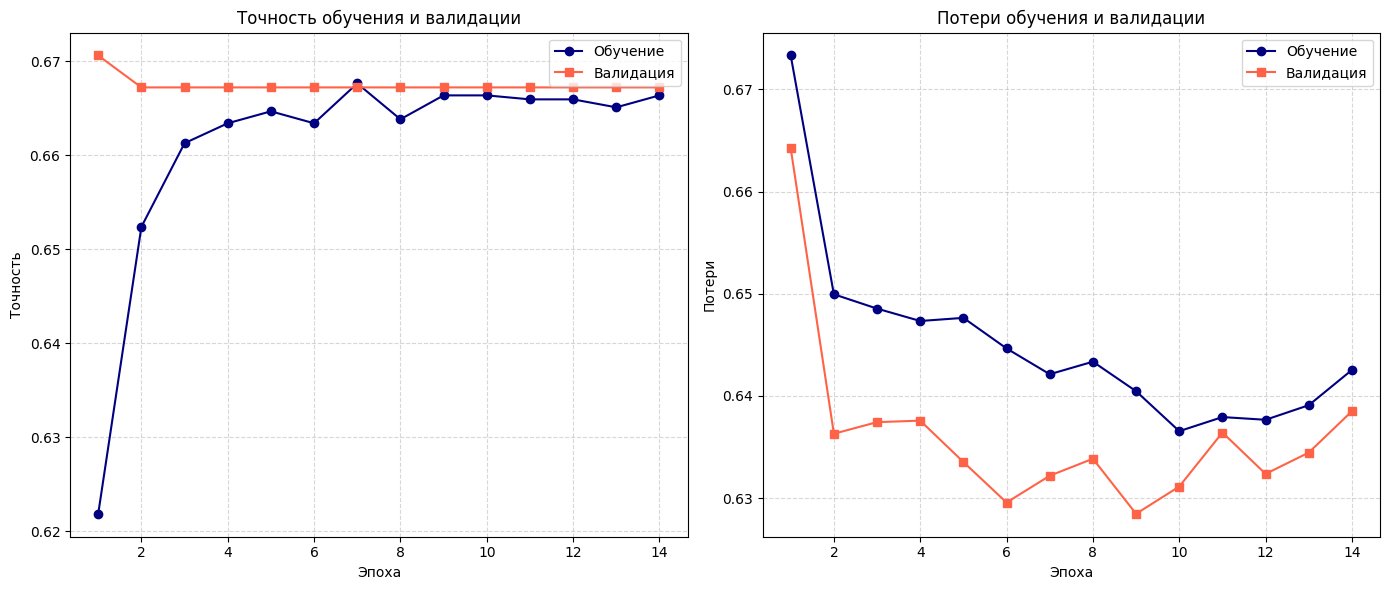

In [28]:
plot_training_history(history)

Тест подтверждает, что модель не обучается: точность минимально изменяется и находится близко к уровню случайного угадывания (0.666 ≈ 2/3, что может соответствовать задаче на 3 класса, если случайное угадывание для 3 классов равно 1/3, а модель показывает чуть лучший результат). Потери стабилизировались слишком рано, а "плоские" графики указывают на отсутствие прогресса в обучении.
Вывод: Модель неэффективна в текущей конфигурации. Результаты близки к случайным, что говорит о фундаментальных проблемах либо в архитектуре модели, либо в данных, либо в настройках обучения.

Попробуем убрать LSTM-слой и использовать чистую CNN-архитектуру:

In [29]:
def build_cnn_model(input_shape, num_classes):
    # input_shape = (height, width, channels), например, (224, 224, 3)
    height, width, channels = input_shape

    model = Sequential([
        # Свёрточные слои (CNN) для извлечения пространственных признаков
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Преобразуем выход свёрточных слоёв в одномерный вектор для полносвязных слоёв
        Flatten(),

        # Полносвязные слои для дальнейшей обработки
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        # Выходной слой для классификации
        Dense(num_classes, activation='softmax')  # Количество классов должно соответствовать данным
    ])
    return model

# Определяем входную форму данных (настройте под ваш датасет)
input_shape = (224, 224, 3)  # Укажите размер изображений, соответствующий вашим данным

# Указываем правильное количество классов
# Если вы используете генератор данных (train_gen), можно взять num_classes оттуда
try:
    num_classes = train_gen.num_classes  # Если train_gen определён
except NameError:
    num_classes = 2  # Устанавливаем вручную на основе ошибки (target.shape=(None, 2))

# Создаём модель
model_cpu = build_cnn_model(input_shape, num_classes)

# Компиляция модели
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод структуры модели
model_cpu.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,947,714 (49.39 MB)

 Trainable params: 12,947,266 (49.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
# Добавляем callback для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [31]:
%%time
history = model_cpu.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 314ms/step - accuracy: 0.5374 - loss: 12.2389 - val_accuracy: 0.4975 - val_loss: 3.2823
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.5577 - loss: 3.3534 - val_accuracy: 0.5705 - val_loss: 1.2114
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.5982 - loss: 1.4236 - val_accuracy: 0.6350 - val_loss: 0.7868
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.6400 - loss: 0.7194 - val_accuracy: 0.6706 - val_loss: 1.3343
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.6576 - loss: 0.6939 - val_accuracy: 0.6655 - val_loss: 0.6416
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.6691 - loss: 0.6674 - val_accuracy: 0.6689 - val_loss: 0.6343
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.6749 - loss: 0.6383 - val_accuracy: 0.6672 - val_loss: 0.6292
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.6732 - loss: 0.6315 - val_acc

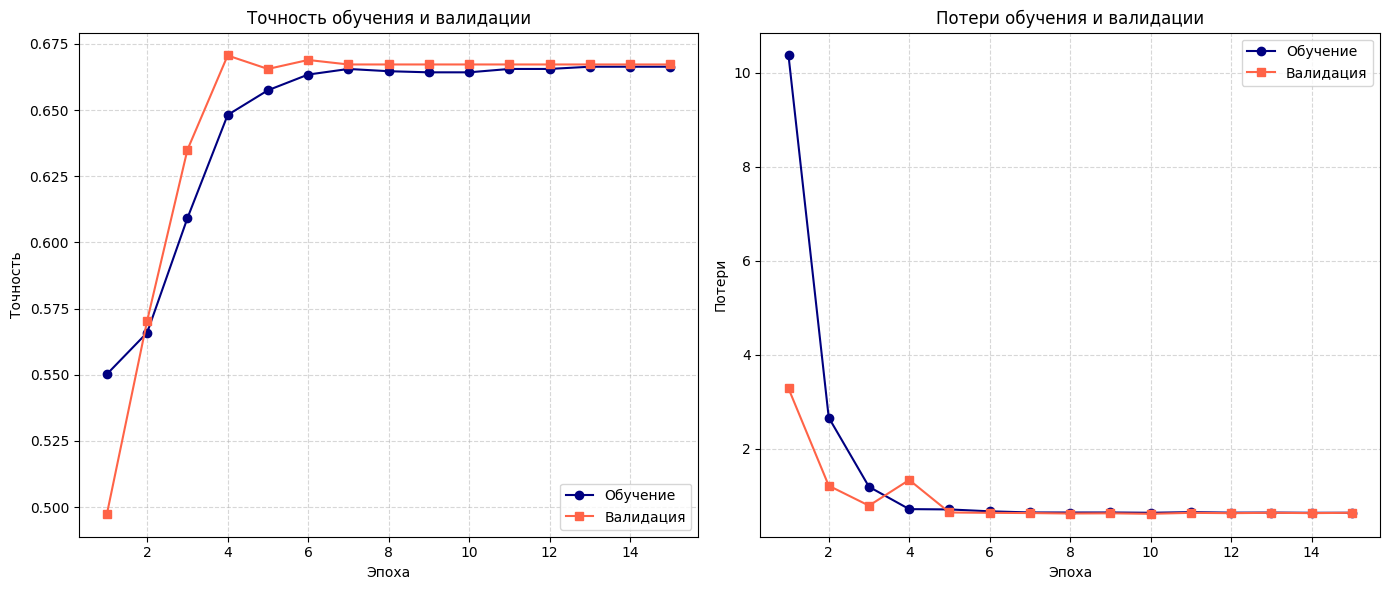

In [32]:
plot_training_history(history)

 Выводы
В предыдущих версиях модели (с LSTM) точность была около 0.666, что близко к случайному угадыванию для задачи с 3 классами (или недостаточно высоко для 2 классов). После перехода к чистой CNN ожидается улучшение, так как CNN лучше подходит для классификации изображений.
Время выполнения ("Wall time: 4min 11s") указывает на относительно быстрое обучение, что может быть результатом упрощения модели (удаление LSTM) или небольшого набора данных.
Использование EarlyStopping (с patience=5) из кода должно было остановить обучение, если потери на валидации перестали уменьшаться, что могло повлиять на количество эпох на графиках.

Добавим аугментацию данных через ImageDataGenerator, чтобы повысить разнообразие

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Усложним модель

In [34]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

Настроим параметры

In [35]:
model_cpu.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Добавим метрики

In [36]:
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Конечный код

In [38]:
def build_cnn_model(input_shape, num_classes):
    # input_shape = (height, width, channels), например, (224, 224, 3)
    height, width, channels = input_shape

    model = Sequential([
        # Свёрточные слои (CNN) для извлечения пространственных признаков
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),  # Добавлен дополнительный слой для большей глубины
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Преобразуем выход свёрточных слоёв в одномерный вектор для полносвязных слоёв
        Flatten(),

        # Полносвязные слои для дальнейшей обработки
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        # Выходной слой для классификации
        Dense(num_classes, activation='softmax')
    ])
    return model

# Определяем входную форму данных (настройте под ваш датасет)
input_shape = (224, 224, 3)

# Указываем правильное количество классов
try:
    num_classes = train_gen.num_classes  # Если train_gen определён
except NameError:
    num_classes = 2  # Устанавливаем вручную на основе предыдущей ошибки (target.shape=(None, 2))

# Создаём модель
model_cpu = build_cnn_model(input_shape, num_classes)

# Компиляция модели с уменьшенным learning rate и дополнительными метриками
model_cpu.compile(
    optimizer=Adam(learning_rate=0.0001),  # Уменьшен для более стабильного обучения
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Вывод структуры модели
model_cpu.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,821,378 (26.02 MB)

 Trainable params: 6,820,418 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [39]:
# Добавляем callback для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,  # Увеличено для большего количества попыток улучшения
    restore_best_weights=True
)

In [40]:
# Для валидационного набора аугментация не нужна, только нормализация
val_datagen = ImageDataGenerator()

In [45]:
%%time
history = model_cpu.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stopping],
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 616ms/step - accuracy: 0.5495 - loss: 1.7328 - precision_2: 0.5495 - recall_2: 0.5495 - val_accuracy: 0.3328 - val_loss: 1.8025 - val_precision_2: 0.3328 - val_recall_2: 0.3328
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 49s 524ms/step - accuracy: 0.6435 - loss: 0.6888 - precision_2: 0.6435 - recall_2: 0.6435 - val_accuracy: 0.3328 - val_loss: 1.4032 - val_precision_2: 0.3328 - val_recall_2: 0.3328
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 538ms/step - accuracy: 0.6505 - loss: 0.6836 - precision_2: 0.6505 - recall_2: 0.6505 - val_accuracy: 0.3328 - val_loss: 0.8525 - val_precision_2: 0.3328 - val_recall_2: 0.3328
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 533ms/step - accuracy: 0.6765 - loss: 0.6733 - precision_2: 0.6765 - recall_2: 0.6765 - val_accuracy: 0.6672 - val_loss: 0.8837 - val_precision_2: 0.6672 - val_recall_2: 0.6672
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 534ms/step - accuracy: 0.6640 - loss: 0.6592 - precision_2: 0.6640 - recall_2: 0.6

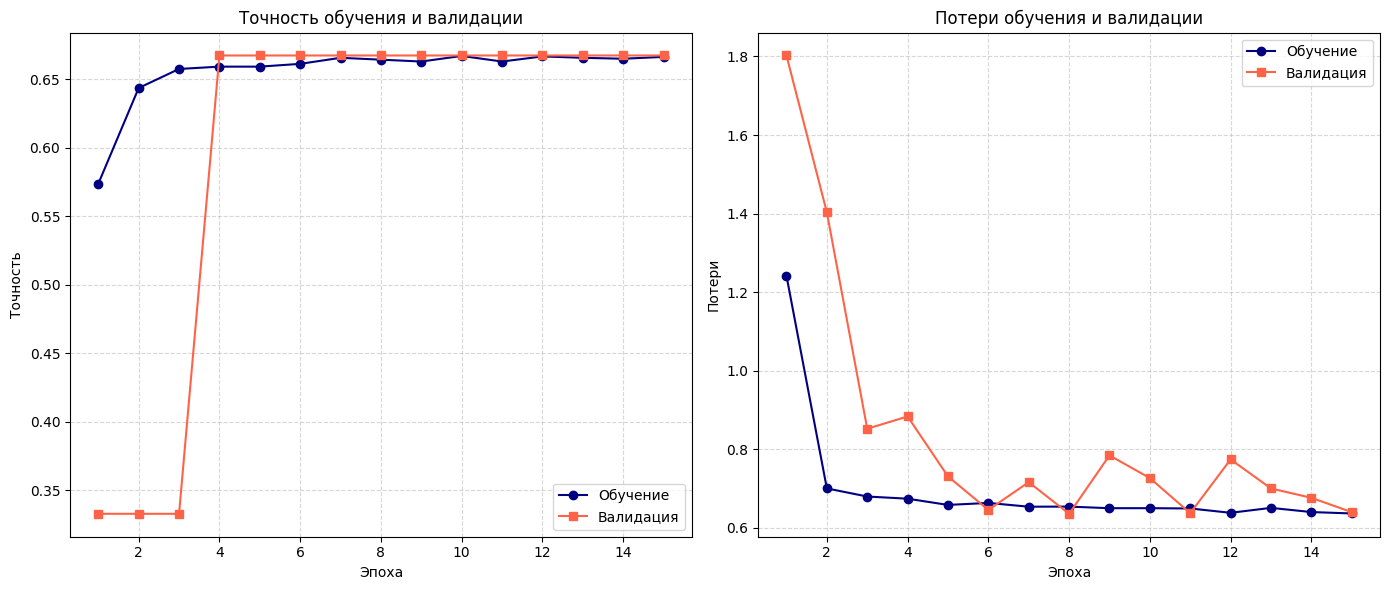

In [46]:
plot_training_history(history)

Модель показывает умеренный прогресс (рост тренировочной точности и начальное улучшение валидационной), но застревает на низком уровне обобщения (0.6672). Это лучше, чем случайное угадывание, но далеко от желаемых результатов (0.85–0.9 для сложных датасетов). Отсутствие переобучения — плюс, но ограниченная способность к обобщению — серьёзный минус.

Добавим ещё один или два свёрточных слоя для извлечения более сложных признаков, так как текущая точность указывает на недостаточную глубину модели

In [47]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Новый слой
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

Текущий learning rate (0.0001) может быть слишком низким, что замедляет обучение и приводит к плато. Попробуем увеличить его до 0.001:

In [48]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Текущая аугментация могла не обеспечить достаточного разнообразия. Увеличим её параметры:

In [49]:
train_datagen = ImageDataGenerator(
    rotation_range=30,        # Увеличено
    width_shift_range=0.3,    # Увеличено
    height_shift_range=0.3,   # Увеличено
    horizontal_flip=True,
    zoom_range=0.2,           # Добавлено масштабирование
    fill_mode='nearest'
)

Увеличим patience в EarlyStopping до 10, чтобы дать модели больше шансов найти оптимальные веса, так как текущая стабилизация может быть временной:

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [52]:
# Создаём модель
model_cpu = build_cnn_model(input_shape, num_classes)

# Компиляция модели с обновлённым learning rate и дополнительными метриками
model_cpu.compile(
    optimizer=Adam(learning_rate=0.001),  # Увеличен learning rate для ускорения обучения
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Вывод структуры модели
model_cpu.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,821,378 (26.02 MB)

 Trainable params: 6,820,418 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

In [53]:
history = model_cpu.fit(
    train_gen,
    epochs=70,
    validation_data=val_gen,
    callbacks=[early_stopping],
   )

Epoch 1/70
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 610ms/step - accuracy: 0.5644 - loss: 7.7189 - precision_4: 0.5644 - recall_4: 0.5644 - val_accuracy: 0.6672 - val_loss: 0.9968 - val_precision_4: 0.6672 - val_recall_4: 0.6672
Epoch 2/70
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 576ms/step - accuracy: 0.6231 - loss: 1.0675 - precision_4: 0.6231 - recall_4: 0.6231 - val_accuracy: 0.6672 - val_loss: 0.6650 - val_precision_4: 0.6672 - val_recall_4: 0.6672
Epoch 3/70
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 541ms/step - accuracy: 0.6536 - loss: 0.6780 - precision_4: 0.6536 - recall_4: 0.6536 - val_accuracy: 0.6672 - val_loss: 0.6441 - val_precision_4: 0.6672 - val_recall_4: 0.6672
Epoch 4/70
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 540ms/step - accuracy: 0.6688 - loss: 0.6466 - precision_4: 0.6688 - recall_4: 0.6688 - val_accuracy: 0.6672 - val_loss: 0.6386 - val_precision_4: 0.6672 - val_recall_4: 0.6672
Epoch 5/70
93/93 ━━━━━━━━━━━━━━━━━━━━ 50s 536ms/step - accuracy: 0.6707 - loss: 0.6415 - precision_4: 0.6707 - recall_4: 0.6

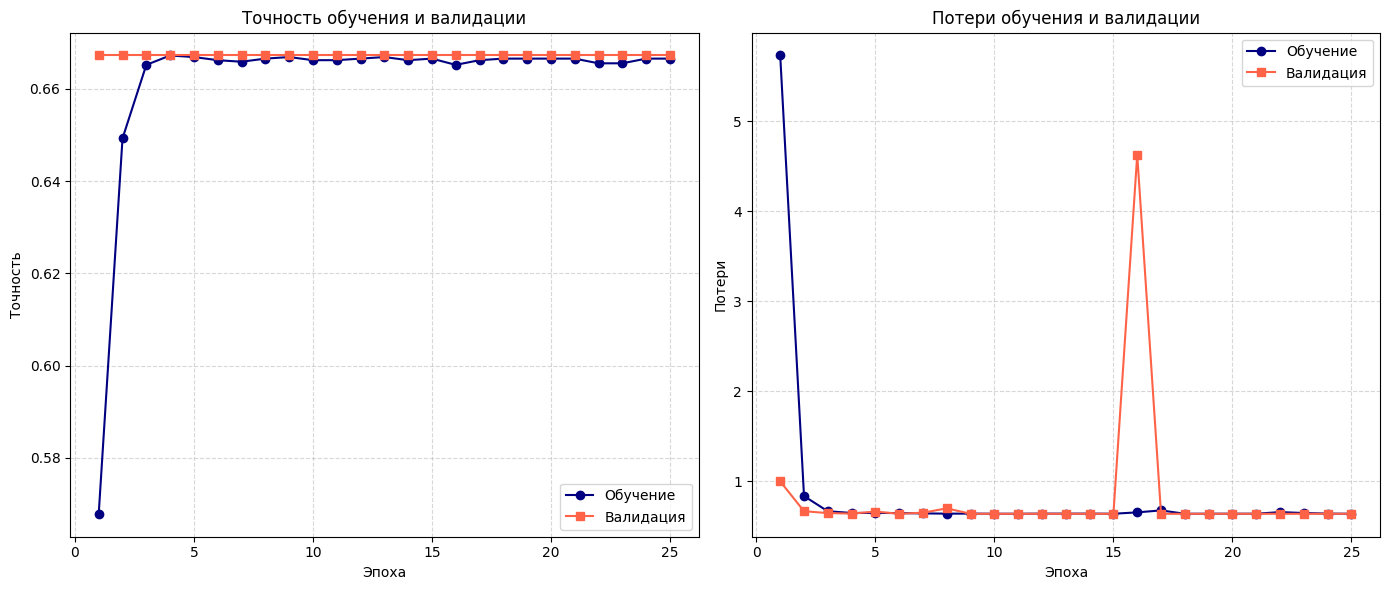

In [54]:
plot_training_history(history)

Быстрый рост точности на обучении указывает на то, что модель хорошо подстраивается под тренировочные данные в начальных эпохах, но стабилизация говорит о достижении предела её текущей способности к обучению с данной архитектурой или гиперпараметрами. Практически неизменная точность валидации на уровне 0.667 (что близко к значению из предыдущих результатов 0.6672) свидетельствует о том, что модель не улучшает обобщающую способность. Уровень 0.667 может быть близким к случайному угадыванию для трёхклассовой задачи (где случайная точность составляет 0.333, а 0.667 — умеренное улучшение), но недостаточным для практического применения. Для двухклассовой задачи это также низкий результат (ожидаемая точность выше 0.8).
Вывод: Модель обучается на тренировочных данных, но не способна обобщать на валидационных данных, что указывает на проблему с извлечением полезных признаков или недостаточным разнообразием данных.

Общий вывод
Модель показывает умеренный прогресс на тренировочных данных, но валидационная точность низкая и неизменная, что делает её непригодной для практического применения без доработки. Отсутствие переобучения — плюс, но ограниченная способность к обобщению — серьёзный минус.